## Advanced Features
####    1. Token Features
######        cwc_min: This is the ratio of the number of common words to the length of the smaller question
######        cwc_max: This is the ratio of the number of common words to the length of the larger question
######        csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
######        csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
######        ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
######        ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
######        last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
######        first_word_eq: 1 if the first word in the two questions is same, 0 otherwise
####    2. Length Based Features
######        mean_len: Mean of the length of the two questions (number of words)
######        abs_len_diff: Absolute difference between the length of the two questions (number of words)
######        longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question
####    3. Fuzzy Features
######        fuzz_ratio: fuzz_ratio score from fuzzywuzzy
######        fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
######        token_sort_ratio: token_sort_ratio from fuzzywuzzy
######        token_set_ratio: token_set_ratio from fuzzywuzzy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("D:/padaii/Datasets/quora.csv")
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
161303,161303,251391,251392,I've purchased a Galaxy S6 in India through Am...,What is North Face's lifetime warranty policy?,0
308903,308903,432814,432815,How much is 2 quarts in ounces?,How much is one ounce of liquid?,0
325433,325433,451681,451682,Liketo Do after b.e MIS or MIS?,How has entertainment media affected the youth...,0
398851,398851,280966,260298,How similar are Philippine President Rodrigo D...,Is it accurate to describe Philippine presiden...,1
25235,25235,29,47048,What are the laws to change your status from a...,What are the laws to change your status from a...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
new_df=df.sample(10000,random_state=2)
new_df

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1
...,...,...,...,...,...,...
89599,89599,150510,150511,What are some examples of instinctive behavior...,Which of the human behaviors are instinctive?,0
358367,358367,487833,487834,"What does ""low-hanging fruit"" mean in research?",What is some low-hanging fruit in microbiology...,0
287931,287931,408788,408789,What is the Tetris effect?,"How can I put games (Tetris, Snake, Maze, etc....",0
59398,59398,26286,104036,What are the companies that conduct workshops ...,What are the companies that conduct workshop o...,0


In [9]:
import re
from bs4 import BeautifulSoup
def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words

    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [10]:
new_df['question1']=new_df['question1'].apply(preprocess)
new_df['question2']=new_df['question2'].apply(preprocess)

C:\Users\ansha\AppData\Local\Temp\ipykernel_120\2513366743.py:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)
C:\Users\ansha\AppData\Local\Temp\ipykernel_120\2513366743.py:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


In [11]:
# LEN

new_df['len_q1']=new_df['question1'].str.len()
new_df['len_q2']=new_df['question2'].str.len()

In [12]:
# No. of Words

new_df['no. of words in q1']=new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['no. of words in q2']=new_df['question2'].apply(lambda row: len(row.split(" ")))

In [13]:
def commonword(row):
    w1= set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2= set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return len(w1 & w2)
new_df['common words']=new_df.apply(commonword,axis=1)

In [14]:
def unique_word_total(row):
    w1= set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2= set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return len(w1)+len(w2)
new_df['word_total']=new_df.apply(unique_word_total,axis=1)

In [15]:
new_df['word_share'] = round(new_df['common words']/new_df['word_total'],2)
new_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,no. of words in q1,no. of words in q2,common words,word_total,word_share
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2,13,0.15
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4,12,0.33
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2,9,0.22


### token features

In [16]:
from nltk.corpus import stopwords
def fetch_token_features(row):
    q1=row['question1']
    q2=row['question2']

    safe_div=0.00001

    stop_words=stopwords.words("english")

    token_features=[0.0]*8

    q1_tokens=q1.split()
    q2_tokens=q2.split()

    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features
    
    # Words in questions
    q1_words=set([word for word in q1_tokens if word not in stop_words])
    q2_words=set([word for word in q2_tokens if word not in stop_words])

    # Stopwords in questions
    q1_stop_words=set([word for word in q1_tokens if word in stop_words])
    q2_stop_words=set([word for word in q1_tokens if word in stop_words])

    common_word_count=len(q1_words.intersection(q2_words))

    common_stop_word_count=len(q1_stop_words.intersection(q2_stop_words))

    common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + safe_div)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + safe_div)
    token_features[2] = common_stop_word_count / (min(len(q1_stop_words), len(q2_stop_words)) + safe_div)
    token_features[3] = common_stop_word_count / (max(len(q1_stop_words), len(q2_stop_words)) + safe_div)
    token_features[4] = common_token_count/ (min(len(q1_tokens), len(q2_tokens)) + safe_div)
    token_features[5] = common_token_count/ (max(len(q1_tokens), len(q2_tokens)) + safe_div)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [17]:
token_features = new_df.apply(fetch_token_features,axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [18]:
new_df.sample(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,no. of words in q1,no. of words in q2,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
24771,24771,46235,46236,what is kashmir issue,what is the kashmir issue,1,21,25,4,5,...,9,0.44,0.999995,0.999995,0.999995,0.999995,0.999998,0.799998,1,1
258364,258364,373911,373912,what is the best thing about being lazy,what are some of the best things about being lazy,1,39,49,8,10,...,18,0.33,0.666664,0.666664,0.999998,0.999998,0.749999,0.599999,1,1
229453,229453,338760,338761,what is singapore,what is singapore known for,0,17,27,3,5,...,8,0.38,0.999990,0.499998,0.999995,0.999995,0.999997,0.599999,0,1


### length features

In [19]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    # Longest common substring 
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [20]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [21]:
new_df.sample(3).sort_values("longest_substr_ratio",ascending=False)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,no. of words in q1,no. of words in q2,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
67637,67637,117025,117026,how do i make make money online with no money ...,how can i make money online with no money to s...,0,63,50,14,11,...,0.999998,0.999999,0.999999,0.818181,0.642857,0,1,3,12.5,0.803922
192304,192304,291913,291914,what intermolecular forces does iodine have,why is no2 an intermolecular force and how is ...,0,43,59,6,11,...,0.249999,0.999997,0.999997,0.166666,0.090909,0,0,5,8.5,0.477273
369862,369862,98497,72948,how do i impress girls,what should i do to impress a girl,1,22,34,5,8,...,0.499998,0.999997,0.999997,0.599999,0.375000,0,0,3,6.5,0.391304


### Fuzzy features

In [22]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

C:\Users\ansha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [23]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [24]:
print(new_df.shape)
new_df.head(3)

(10000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,no. of words in q1,no. of words in q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,0.250000,1,0,3,6.5,0.615385,59,68,50,75
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,0.571428,1,0,2,6.0,0.500000,71,82,63,84
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,0.333333,0,1,3,4.5,0.476190,67,85,60,60


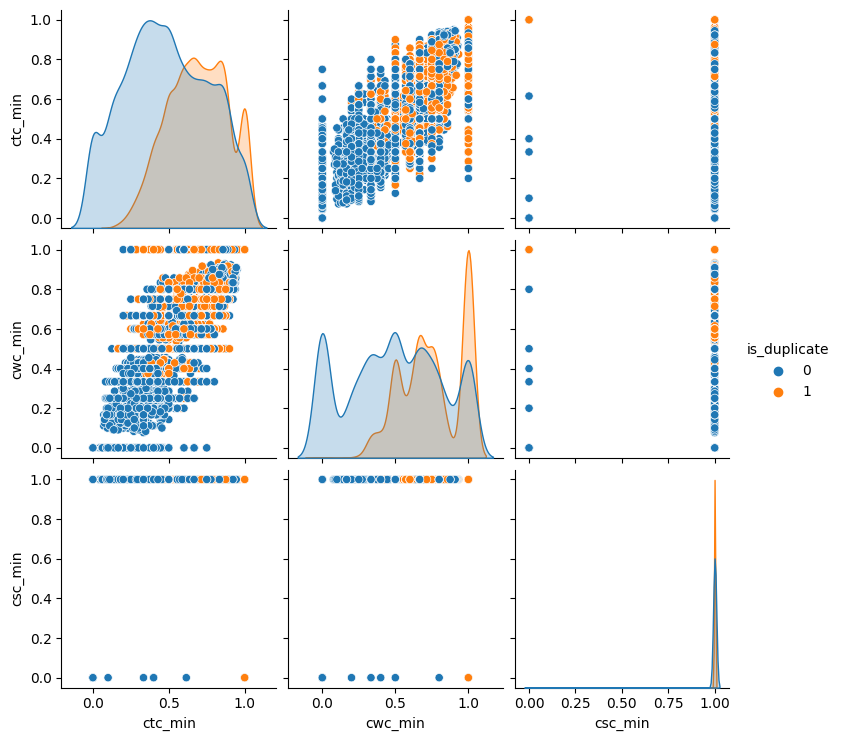

In [25]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

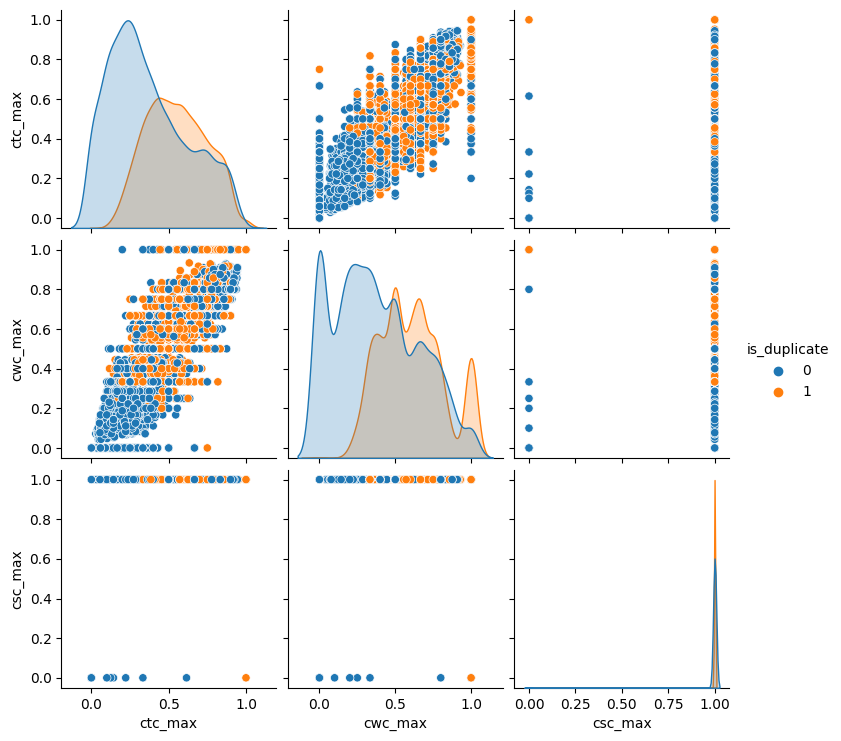

In [26]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

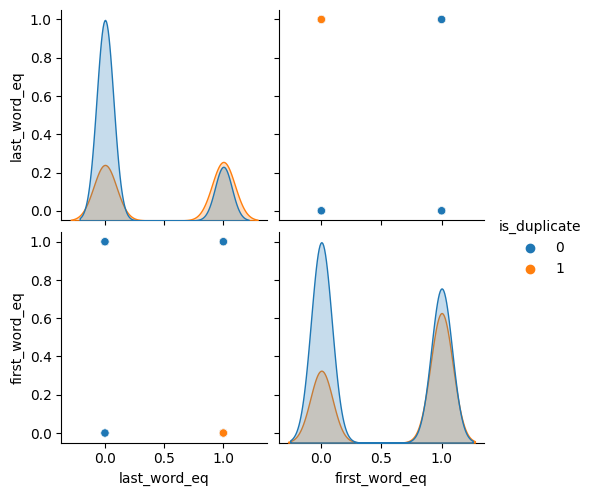

In [27]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

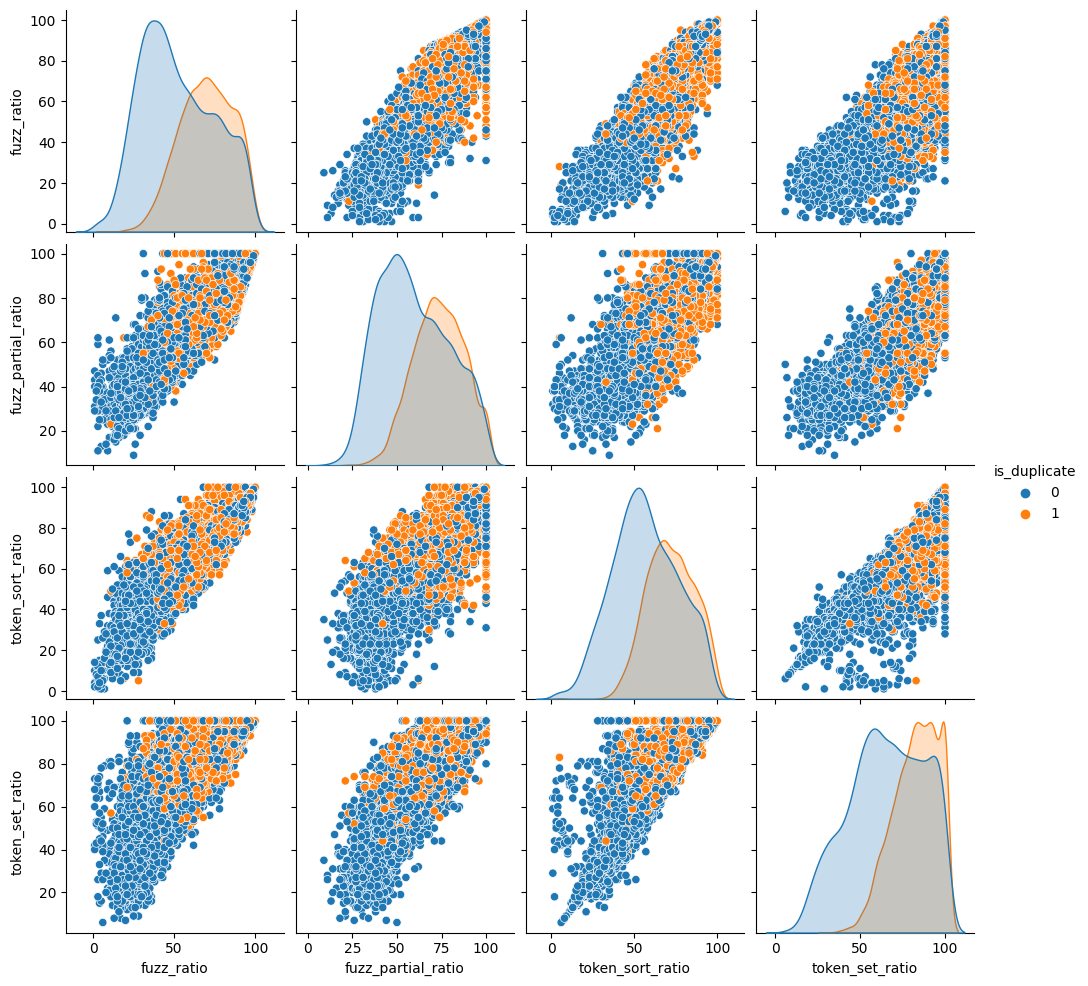

In [28]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

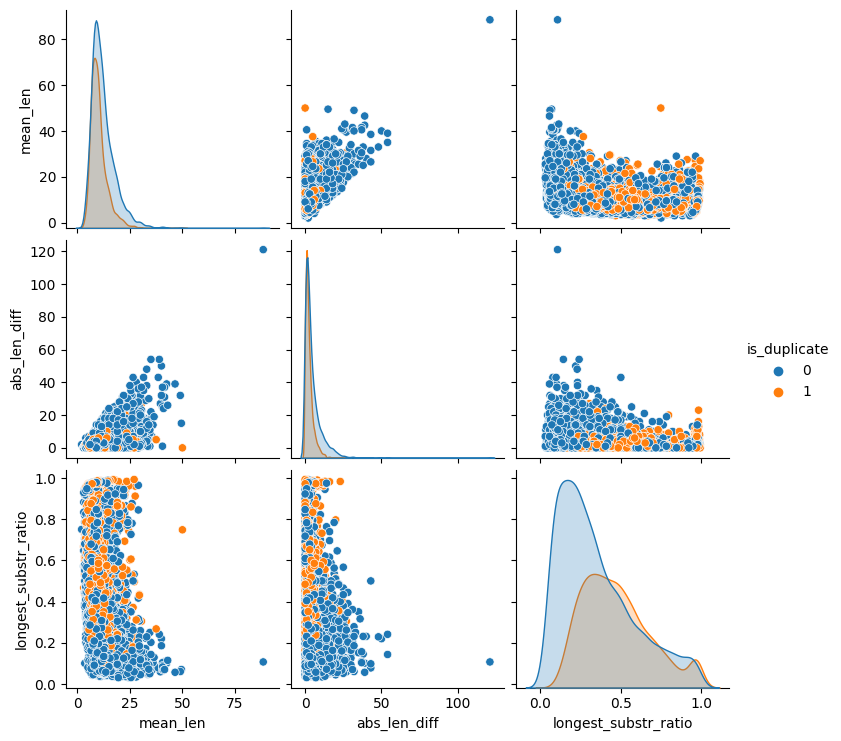

In [29]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

In [26]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [31]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.132s...
[t-SNE] Computed neighbors for 10000 samples in 1.970s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.093172
[t-SNE] Computed conditional probabilities in 0.365s
[t-SNE] Iteration 50: error = 95.4453125, gradient norm = 0.0555690 (50 iterations in 6.112s)
[t-SNE] It

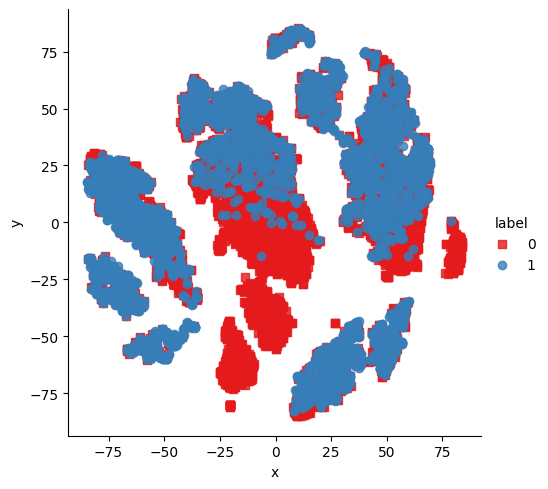

In [33]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])

In [27]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
331535,how can i learn norwegian,what is the quickest way to learn norwegian
45407,how are currency rates determined,where and how are exchange rates determined
286200,what is substitution,what is a substitute for caciocavallo
157195,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...
154346,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...


In [28]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(10000, 23)


,is_duplicate,len_q1,len_q2,no. of words in q1,no. of words in q2,common words,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
331535,1,25,43,5,8,2,13,0.15,0.999995,0.499999,...,0.250000,1,0,3,6.5,0.615385,59,68,50,75
45407,1,33,43,5,7,4,12,0.33,0.666664,0.666664,...,0.571428,1,0,2,6.0,0.500000,71,82,63,84
286200,0,20,37,3,6,2,9,0.22,0.000000,0.000000,...,0.333333,0,1,3,4.5,0.476190,67,85,60,60
157195,1,44,72,11,17,6,27,0.22,0.666666,0.571428,...,0.375000,0,0,5,13.5,0.244444,45,55,61,76
154346,1,58,63,11,12,8,23,0.35,0.999998,0.799998,...,0.666666,1,0,1,11.5,0.355932,81,81,78,86


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [30]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(10000, 6000)

In [31]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(10000, 6023)


,is_duplicate,len_q1,len_q2,no. of words in q1,no. of words in q2,common words,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
331535,1,25,43,5,8,2,13,0.15,0.999995,0.499999,...,0,0,0,0,0,0,0,0,0,0
45407,1,33,43,5,7,4,12,0.33,0.666664,0.666664,...,0,0,0,0,0,0,0,0,0,0
286200,0,20,37,3,6,2,9,0.22,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
157195,1,44,72,11,17,6,27,0.22,0.666666,0.571428,...,0,0,0,0,0,0,0,0,0,0
154346,1,58,63,11,12,8,23,0.35,0.999998,0.799998,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=0)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.754

In [43]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7515

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[997, 247],
       [245, 511]], dtype=int64)

In [45]:
confusion_matrix(y_test,y_pred1)

array([[972, 272],
       [225, 531]], dtype=int64)

In [35]:
from sklearn import svm
svc=svm.SVC(kernel='rbf',gamma=0.5,C=1)
svc.fit(X_train,y_train)
ypred=svc.predict(X_test)

In [ ]:
confusion_matrix(y_test,ypred)